# Basic Analysis

## Tweet and user volume

In [43]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv ('IchBinHanna.csv')

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (6,8,9,10,13,37,41,42,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#number of total tweets
print(df.shape[0])
#number of total unique users
print(len(pd.unique(df['author.id'])))

116928
19010


In [59]:
#only keep tweets from 01/06/2021 - 30/09/2021
from datetime import datetime
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_date = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [6]:
pd.set_option('display.max_rows', 100)
#number of remaining tweets
print(df_date.shape[0])
#number of remaining unique users
print(len(pd.unique(df_date['author.id'])))
#overview over "missing values"
print(df_date.count())

116717
18987
__twarc.retrieved_at                                98885
__twarc.url                                         98885
__twarc.version                                     98885
attachments.media                                    3287
attachments.media_keys                               3287
attachments.poll.duration_minutes                      83
attachments.poll.end_datetime                          83
attachments.poll.id                                    83
attachments.poll.options                               83
attachments.poll.voting_status                         83
attachments.poll_ids                                   89
author.created_at                                  116717
author.description                                 111104
author.entities.description.cashtags                    9
author.entities.description.hashtags                40708
author.entities.description.mentions                51884
author.entities.description.urls                     7687
a

<AxesSubplot:xlabel='week'>

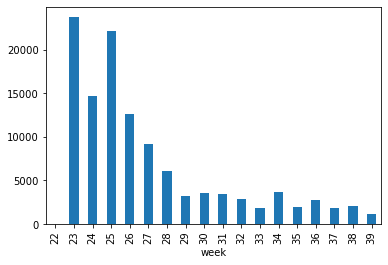

In [7]:
from matplotlib import pyplot as plt
week_groups = df_date.groupby([pd.to_datetime(df_date['new_date']).dt.isocalendar().week]).size()
week_groups.plot(kind='bar', legend = False)

In [8]:
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]

<AxesSubplot:xlabel='new_date'>

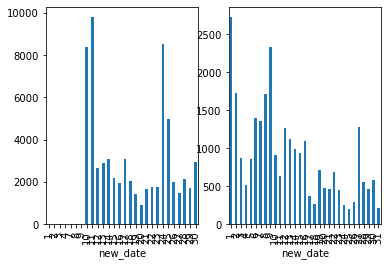

In [9]:
june_groups = df_june.groupby([pd.to_datetime(df_june['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
june_groups.plot(kind='bar', legend = False)
july_groups = df_july.groupby([pd.to_datetime(df_july['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
july_groups.plot(kind='bar', legend = False)

<AxesSubplot:xlabel='new_date'>

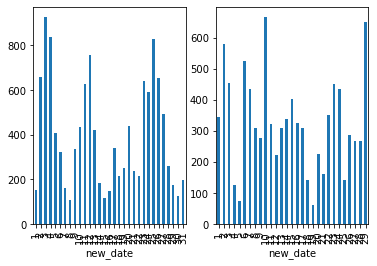

In [10]:
august_groups = df_august.groupby([pd.to_datetime(df_august['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
august_groups.plot(kind='bar', legend = False)
september_groups = df_september.groupby([pd.to_datetime(df_september['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
september_groups.plot(kind='bar', legend = False)

## Missing Hashtag-Problem

In [11]:
#number of tweets actually containing the hashtag
df_hash = df_date[df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_hash.shape[0])

64400


In [12]:
#number of tweets not containing the hashtag directly
df_no_hash = df_date[-df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_no_hash.shape[0])

52317


In [13]:
pd.options.display.max_colwidth = 500
print(df_no_hash['text'])
#number of tweets without the hashtag that are retweets (text from original tweet cut off)
print(df_no_hash[df_no_hash['reference_type'] == 'retweeted'].shape[0])

2         Hanna is probably packing her/his/they suitcases. Hanna is about to travel back to her/his/they city or her/his/they country. Hanna can't pay the rent, can't buy food, doesn't have her/his/they visa renewed.
5                                                                           RT @TimTheRose: Am Donnerstag moderiere ich eine Diskussionsrunde mit MdB @NicoleGohlke in #Freising.\nAls Fraktionssprecherin fuer #Hochsch…
11                                                                       RT @AmreiBahr: Mangelnde Grundfinanzierung der Hochschulen baden Wissenschaftler_innen aus: Risiken werden individualisiert &amp; auf sie abgew…
12                                                                       RT @AmreiBahr: Mangelnde Grundfinanzierung der Hochschulen baden Wissenschaftler_innen aus: Risiken werden individualisiert &amp; auf sie abgew…
16                                                                          RT @TimTheRose: Am Donnerstag moderiere ich eine Dis

In [109]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df_no_hash.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Get top hashtags appearing in tweets along with #IchBinHanna in september

In [103]:
#make the hashtags a list of strings and replace the hashtag #ichbinhanna
df_date['hashtags'] = df_date['hashtags'].str.replace('[', '').str.replace(']','')

C:\Users\Admin\AppData\Local\Temp/ipykernel_15200/3598185478.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_september['hashtags'] = df_september['hashtags'].str.replace('[', '').str.replace(']','')
C:\Users\Admin\AppData\Local\Temp/ipykernel_15200/3598185478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_september['hashtags'] = df_september['hashtags'].str.replace('[', '').str.replace(']','')


In [104]:
df_date['hashtags separated'] = df_date['hashtags'].str.split(',')


C:\Users\Admin\AppData\Local\Temp/ipykernel_15200/2159421236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_september['hashtags separated'] = df_september['hashtags'].str.split(',')


In [105]:
#flatten the lists to count occurences of all strings and drop all variations of #IchBinHanna
flat_hashtags = df_september['hashtags separated'].explode().to_frame().dropna()
flat_hashtags = flat_hashtags[-flat_hashtags['hashtags separated'].str.contains("ichbinhanna", case = False)]

In [121]:
#count occurences 
hashtag_count = flat_hashtags.value_counts()
hashtag_count = hashtag_count[hashtag_count > 10].reset_index()

In [122]:
compression_opts = dict(method='zip',
                        archive_name='top_hashtags.csv')  
hashtag_count.to_csv('out.zip', index=False,
          compression=compression_opts) 